In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
one_year = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= '2016-08-23').\
                        order_by(Measurement.date).all()
# Calculate the date 1 year ago from the last data point in the database
last_year_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year_date
# Perform a query to retrieve the data and precipitation scores
data_query= engine.execute('SELECT date, prcp FROM measurement').fetchall()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(one_year, columns=['date', 'prcp'])
prcp_df.set_index(prcp_df['date'])
prcp_df.head()


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


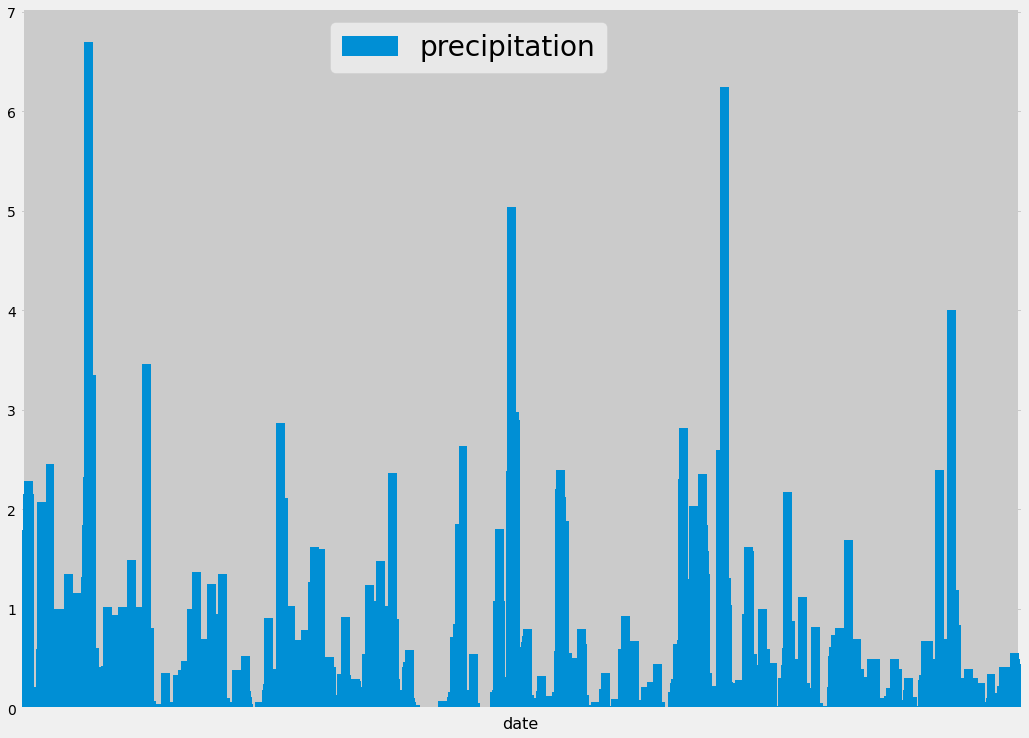

In [13]:
ax= prcp_df.plot.bar(figsize=(16,12), width=20)
ax.set_xlabel("date", fontsize=16)
ax.set_xticklabels([])
plt.legend(['precipitation'], fontsize=28)
ax.get_legend().set_bbox_to_anchor((0.6, 1))

plt.show()


In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9,)]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()

[(53.0, 87.0, 73.09795396419437)]

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_temp_obs = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.date >= '2016-08-23')\
    .filter(Measurement.station == 'USC00519281')\
    .all()
max_temp_df = pd.DataFrame(max_temp_obs)
max_temp_df.head()


,0,1
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


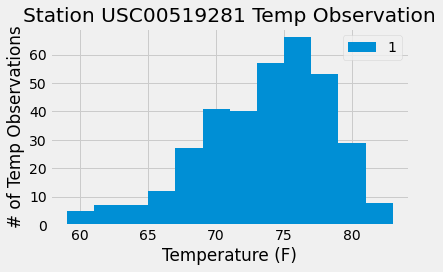

In [29]:
#plot the results
max_temp_df.plot.hist(bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("# of Temp Observations")
plt.title("Station USC00519281 Temp Observation")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_yr_trip_start = '2016-08-15'
prev_yr_trip_end = '2016-08-23'
print(calc_temps(prev_yr_trip_start, prev_yr_trip_end))

[(72.0, 78.0677966101695, 82.0)]


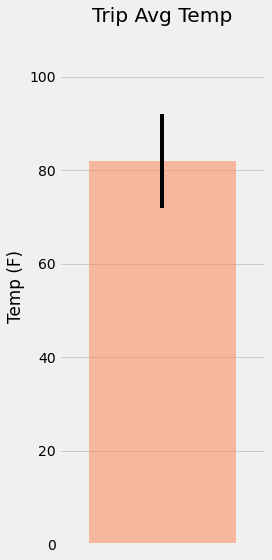

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = calc_temps(prev_yr_trip_start, prev_yr_trip_end)

trip_avg = trip_temps[0][1]
trip_min = trip_temps[0][0]
trip_max = trip_temps[0][2]
yerr = [trip_max - trip_min]

fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, trip_max, yerr=yerr,alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

print(precipitation(prev_yr_trip_start, prev_yr_trip_end))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.95), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.23), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.17), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [37]:
# Plot the daily normals as an area plot with `stacked=False`
